<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/12_timeseries/deli_proj_pract_12_v2_1_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №12**</b></font>
    
<font size=6><b>**Временные ряды**</b></font>

***

# Постановка задачи

**Заказчик**  
Компания «Чётенькое такси».

**Цель**  
Построить модель для предсказания количества заказов такси на следующий час с целью привлечения больше водителей в период пиковой нагрузки. 

**Задачи**  

1. Проанализировать данные;
1. Обучить разные модели с различными гиперпараметрами, выбрать лучшую на валидационной выборке;
1. Сделать тестовую выборку размером 10% от исходных данных;
1. Проверить данные на тестовой выборке и сделать выводы.

**Исходные данные**  
Исторические данные о заказах такси в аэропортах. 
Качество предсказания следует оценивать метрикой RMSE.
Значение метрики на тестовой выборке должно быть не больше 48 шт.


# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    from catboost import CatBoostRegressor, Pool
except:
    !pip install catboost
    from catboost import CatBoostRegressor, Pool
# Темная тема графиков
plt.style.use("dark_background")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Загрузим сами данные.

In [ ]:
df = pd.read_csv("D:/Jupyter/practicum_12/taxi.csv", parse_dates=[0], index_col=[0])

# Exploratory Data Analysis

## Обзор данных

Вызовем первые 5 строк и общую информацию о таблице.

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В рассматриваемом датафрейме содержаться данные по количеству заказов в период с 1 марта по 31 августа 2018 года, сгруппированные по 10 минут.
Общее количество объектов составляет 26496, пропуски отсутствуют.
Учитывая, что в датафрейме всего один столбец, количество дублирующихся значений не представляет интерес.

Проверим, что количество объектов соответствует заданному интервалу.

In [ ]:
6 * 24 * (31 * 4 + 30 * 2)
# слагаемое 1 - количество объектов за час
# слагаемое 2 - количество часов в сутках
# слагаемое 3 и 5 - количество суток
# слагаемое 4 - количество месяцев с числом дней 31
# слагаемое 6 - количество месяцев с числом дней 30

26496

Расчетное значение совпадает с количеством объектов.

Построим гистограмму распределения количества заказов и график их изменения во времени.
Предварительно проведем сортировку датафрейма по индексу (времени).

In [ ]:
df.sort_index(inplace=True)


def hist_and_plot(df):
    _, axs = plt.subplots(1, 2, figsize=(14, 5))
    df.hist(bins=30, ax=axs[0])
    axs[0].set_title("Гистограмма распределения количества заказов")
    axs[0].set_ylabel("Количество записей о заказах, шт.")
    axs[0].set_xlabel("Количество заказов, шт.")

    df.plot(ax=axs[1])
    axs[1].set_title("График изменения количества заказов")
    axs[1].set_ylabel("Количество заказов, шт.")
    axs[1].set_xlabel("Дата")

    plt.show()

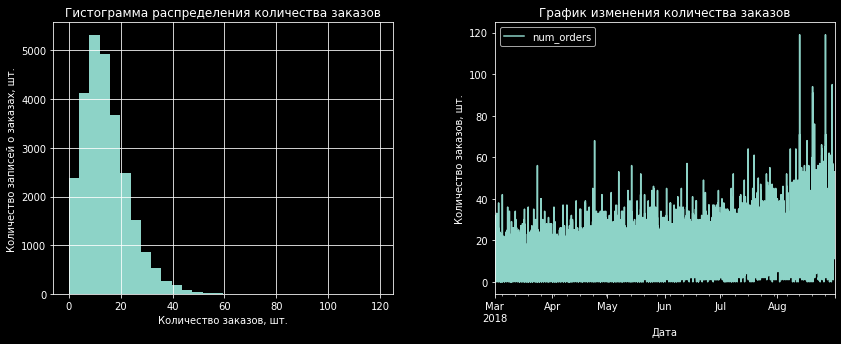

In [ ]:
hist_and_plot(df)

Распределение на гистограмме соответствует теоретической форме распределения Пуассона. 

График изменения количества заказов неинформативный и построение модели машинного обучения по нему не принесет положительных результатов. 
В этой связи представляется целесообразным ресэмплирование данных и введение дополнительных признаков, позволяющих прогнозировать целевой признак.

## Ресэмплирование

Согласно заданию, требуется предсказание значений заказов на следующий час.
Таким образом, ресэмплирование целесообразно проводить суммированием значений в рамках одного часа.

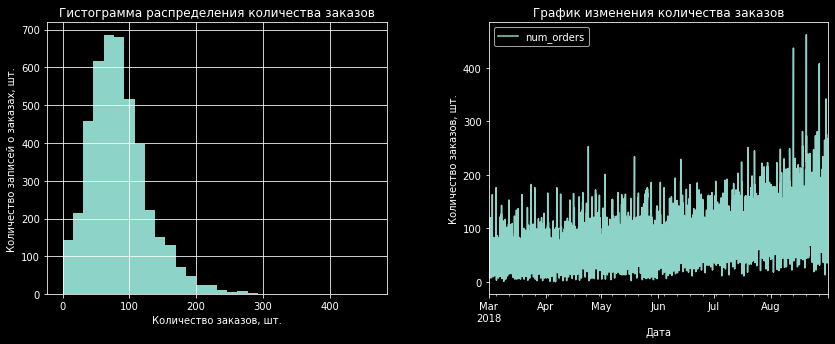

In [ ]:
hist_and_plot(df.resample("1H").sum())

In [ ]:
df = df.resample("1H").sum()

Внешний вид гистограммы практически не изменился, за исключением масштаба единиц измерения.
Аналогичным образом изменился график, при этом на нем хорошо видны выбросы на более поздних датах, которые могут повредить оценке качества разрабатываемой модели.

## Тренд количества заказов

Оценим общий тренд количества заказов такси при помощи соответствующей функции.

In [ ]:
decomposed = seasonal_decompose(df["num_orders"])

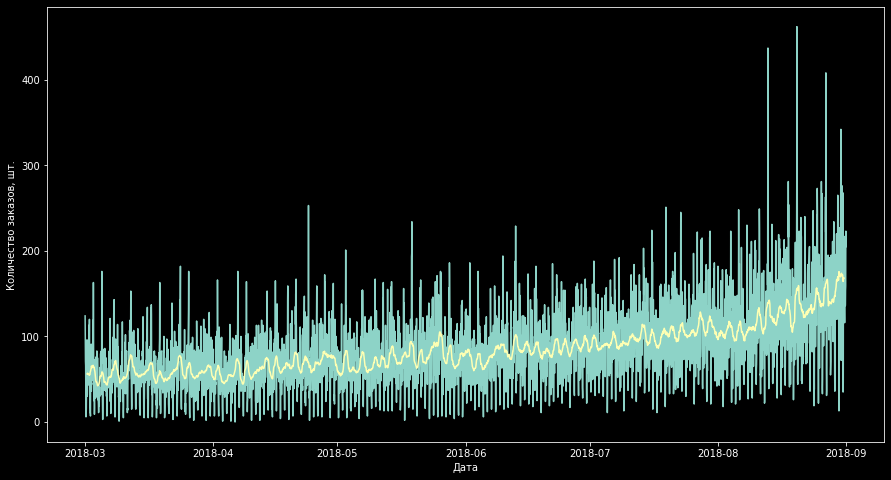

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df["num_orders"])
plt.plot(decomposed.trend)
plt.ylabel("Количество заказов, шт.")
plt.xlabel("Дата")
plt.show()

По полученному графику хорошо видно, что тренд имеет положительный знак.
При этом, значение самого тренда за рассматриваемые шесть месяцев увеличилось в два раза.
По всей видимости, это объясняться развитием сервисов такси и повышением их доступности.
Для дальнейшего анализа необходимо получение более подробной информации о рассматриваемом датафрейме, например, название или расположение аэропорта и т.п.

В целом, форма тренда похожа на скользящее среднее.
Использование последнего позволит повысить робастность модели машинного обучения, так как его возможно использовать за пределом диапазона рассматриваемых дат. 

Построим графики скользящего среднего с различным временем осреднения для выбора наилучшего совпадения с трендом.

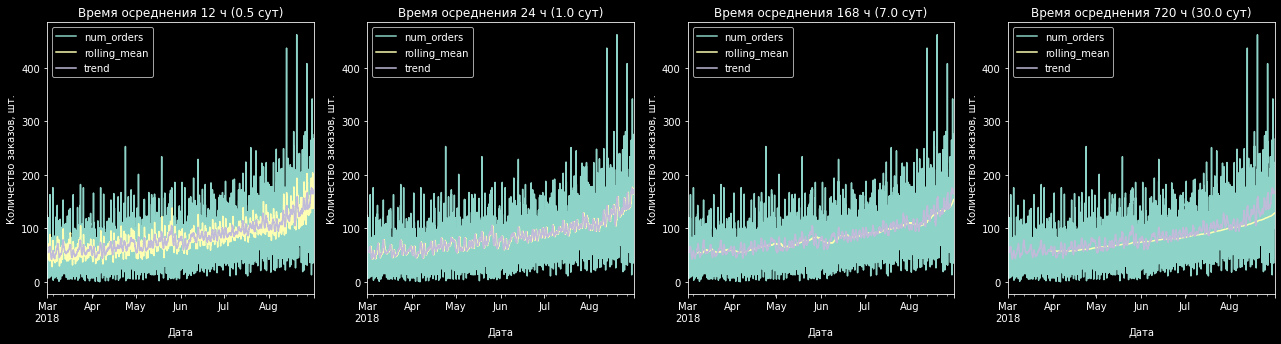

In [ ]:
rols = [12, 24, 24 * 7, 24 * 30]

_, axs = plt.subplots(1, len(rols), figsize=(22, 5))
for i in range(len(rols)):

    df["num_orders"].plot(ax=axs[i], label="num_orders")
    df["num_orders"].rolling(rols[i]).mean().plot(ax=axs[i], label="rolling_mean")
    decomposed.trend.plot(
        ax=axs[i], label="trend", ylabel="Количество заказов, шт.", xlabel="Дата"
    )

    axs[i].set_title(f"Время осреднения {rols[i]} ч ({rols[i] / 24} сут)")
    axs[i].legend()

plt.show()

По полученным графикам видно, что наилучшее совпадение тренда и скользящего среднего осуществляется при времени осреднения 24 ч.
Сохраним посчитанное среднее в отдельную переменную.
Учитывая, что полученный признак содержит сведения о целевой переменной, в датафрейм его необходимо включать со сдвигом.

In [ ]:
df["rolling_mean_shift_1"] = df["num_orders"].rolling(rols[1]).mean().shift()

Из полученных графиков хорошо видна нелинейность среднего значения.
Для линеаризации характеристики выполним ее дифференцирование дискретным способом.

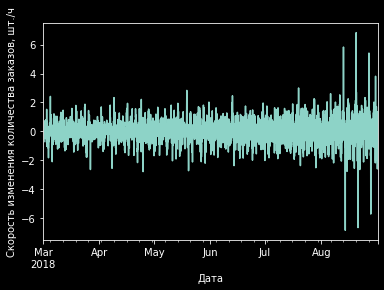

0.012786571016473089

In [ ]:
((df["rolling_mean_shift_1"] - df["rolling_mean_shift_1"].shift()) / 2).plot(
    ylabel="Скорость изменения количества заказов, шт./ч", xlabel="Дата"
)
plt.show()
((df["rolling_mean_shift_1"] - df["rolling_mean_shift_1"].shift()) / 2).mean()

Среднее значение полученной характеристики близко к нулю.
В этой связи представляется целесообразным включение в список признаков сдвиг среднего значения на одну позицию. 
В этом случае выполнение операции дифференцирования модель машинного обучения выполнит самостоятельно.
Введение дальнейших сдвигов значений введет в модель еще большую нелинейность, чем была изначально, что повлияет на качество предсказания.

In [ ]:
df["rolling_mean_shift_2"] = df["rolling_mean_shift_1"].shift()

## Сезонность количества заказов

Построим график сезонности в масштабе двух дней.

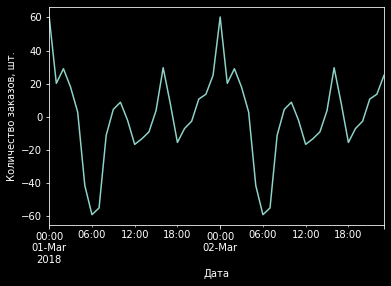

In [ ]:
decomposed.seasonal["2018-03-01":"2018-03-02"].plot(
    ylabel="Количество заказов, шт.", xlabel="Дата"
)
plt.show()

Из графика хорошо видно, что сезонность ограничена одним днем, а ее значение в пике соизмеримо со значением тренда.
При этом, пик заказов приходится на полночь, а анти-пик на 6 утра.
Локальные максимумы и минимумы могут объясняться временем прилета или отлета регулярных рейсов.

Для учета сезонности в модели машинного обучения сохраним ее в качестве признака.
Несмотря на то, что такой признак содержит информацию о целевом признаке, его можно использовать, так как он обладает регулярной периодичностью.

Для повышения качества предсказания сохраним в качестве отдельных признаков сдвиг на 24 часа и сдвиг на 1 неделю.

In [ ]:
df["seasonal"] = decomposed.seasonal

In [ ]:
df["seasonal_day"] = df["num_orders"].shift(24)
df["seasonal_week"] = df["num_orders"].shift(24*7)

## Оценка шума

Построим график шума в данных.

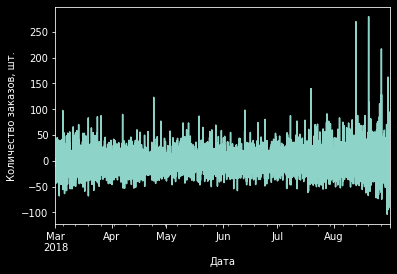

In [ ]:
decomposed.resid.plot(ylabel="Количество заказов, шт.", xlabel="Дата")
plt.show()

Из графика видно, что амплитуда шумовой составляющей в данных сопоставима с амплитудой сезонности и тренда.
Для ее оценки построим гистограмму плотности распределения значений, а также посчитаем среднее значение и стандартное отклонение от него.

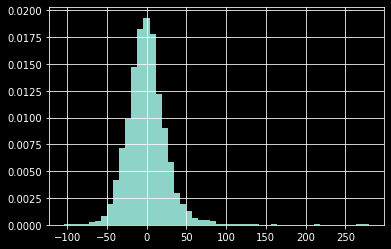

In [ ]:
decomposed.resid.hist(bins=50, density=True)
plt.show()

In [ ]:
decomposed.resid.mean(), decomposed.resid.std()

(-0.008130312689736007, 24.696895960143493)

По представленным данным хорошо видно, что шум является центрированной случайной величиной со стандартным отклонением равным 24,7.

Подобные величины не нуждаются в определении в качестве признаков для моделей машинного обучения.
В то же время, такой признак хорошо интерпретируем и будет полезен при определении опорного значения (baseline) качества предсказания.
Определим признак как случайное число с соответствующими характеристиками.

In [ ]:
np.random.seed(26)
df["noise"] = np.random.normal(scale=decomposed.resid.std(), size=(len(df)))

Построим на одном графике полученный признак и шумы в данных.

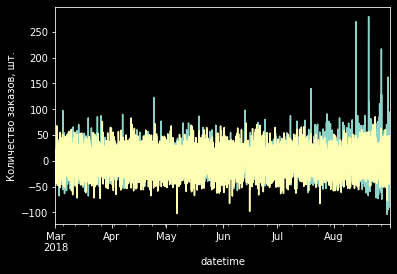

In [ ]:
decomposed.resid.plot(ylabel="Количество заказов, шт.", xlabel="Дата")
df["noise"].plot()
plt.show()

Визуально, оба графика очень близки друг к другу.
Однако в более поздних датах видно расхождение, что может быть вызвано или нестационарностью процесса, или наличием неучтенной сезонности в течение года.

## Заключение по EDA

Рассмотрен и проведен анализ датафрейма о заказах такси в аэропортах.  
В результате анализа получено, что в данных присутствует тренд, сезонность и шумы.
Первая характеристика увеличивается со временем по нелинейному закону.
Вторая - ограничена одним днем, а третья - имеет нормальное распределение вокруг нулевого значения.  
Абсолютные величины всех категорий данных соизмеримы, в связи с чем они преобразованы в признаки для учета в моделях машинного обучения.

# Моделирование

## Подготовка данных

В результате разработки признаков датафрейм наполнился объектами с пропусками, которые необходимо удалить.

In [ ]:
df = df.dropna()

Добавим дополнительный признак, соответствующий дню недели, что может помочь при определении сезонности.

In [ ]:
df["dayofweek"] = df.index.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Для корректной работы модели Prophet добавим в датафрейм столбец, дублирующий индекс, а название столбца с целевым признаком переименуем в `y`.

In [ ]:
df["ds"] = df.index
df = df.rename(columns={"num_orders": 'y'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Определим целевой и "рабочие" признаки.

In [ ]:
y = ["y"]

In [ ]:
X = list(df.drop(["y", 'ds'],axis=1).columns)

Создадим обучающую, валидационную и тестовую выборки в пропорциях 8:1:1.

In [ ]:
end1 = int(len(df)*.8)
end2 = int(len(df)*.9)

train = df[0:end1]
val = df[end1:end2]
test = df[end2:]
len(train), len(val), len(test)

(3398, 425, 425)

train, val_test = train_test_split(df, shuffle=False, test_size=0.2)
val, test = train_test_split(val_test, shuffle=False, test_size=0.5)
len(train), len(val), len(test)

## Baseline

Для оценки качества предсказания моделей машинного обучения создадим опорную модель.
Учитывая нестационарность процесса, предсказания простым средним или медианным значением представляется нецелесообразным.
В этой связи рассмотрим качество предсказаний по одной из двух формул:
$$
NO = NO_{-1} + \frac{NO_{-2} - NO_{-1}}{2}
$$
или
$$
NO = RM_{-1} + \frac{RM_{-2} - RM_{-1}}{2} + S + N,
$$

где NO - признак `num_orders`, S - признак `seasonal`, RM - признак `rolling_mean`, N - признак `noise`.
Нижний регистр `-1` означает, что признак используется с предыдущего шага, а `-2` - с шага, предшествующего предыдущему.

Смысл первого выражения заключается в том, что для предсказания действующего шага используется предыдущее значение и его приращение на предыдущем шаге. 
При этом предполагается, что приращение не должно быстро изменяться.

Во втором выражении целевой признак раскладывается на сумму тренда, сезонной и шумовой составляющих.
При этом выражение второго слагаемого определено однозначно, а последнее - описывается центрированной случайной величиной с заданной дисперсией.
Значение тренда определяется исходя из суммы предыдущего значения и его приращения на предыдущем шаге.

Определим MSE для каждого выражения.

In [ ]:
mean_squared_error(
    val[y],
    (
        val["y"].shift()
        + (val["y"].shift(2) - val["y"].shift()) / 2
    ).fillna(0),
    squared=False,
)

48.22343828471794

In [ ]:
val["baseline"] = (
    val["rolling_mean_shift_1"]
    + (val["rolling_mean_shift_2"] - val["rolling_mean_shift_1"]) / 2
    + val["seasonal"]
    + val["noise"]
)
mse_baseline = mean_squared_error(val[y], val["baseline"], squared=False)
mse_baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


38.89735394044811

По полученным значениям хорошо видно, что для второго выражения качество предсказания лучше.
Кроме того, оно лучше заданного по заданию предела. 
Следовательно, такое аналитическое выражение может использоваться для получения сверхбыстрых предсказаний. 

Для наглядности построим график действительных значений и предсказанных.

In [ ]:
def plot_pred(pred):
    plt.figure(figsize=(20, 8))
    plt.plot(train["2018-07-15":][y], label="train")
    plt.plot(val[y], label="val_true", alpha=0.75)
    plt.plot(val[pred], label="val_pred", alpha=0.75)
    plt.ylabel("Количество заказов, шт.")
    plt.xlabel("Дата")
    plt.legend(loc=2)

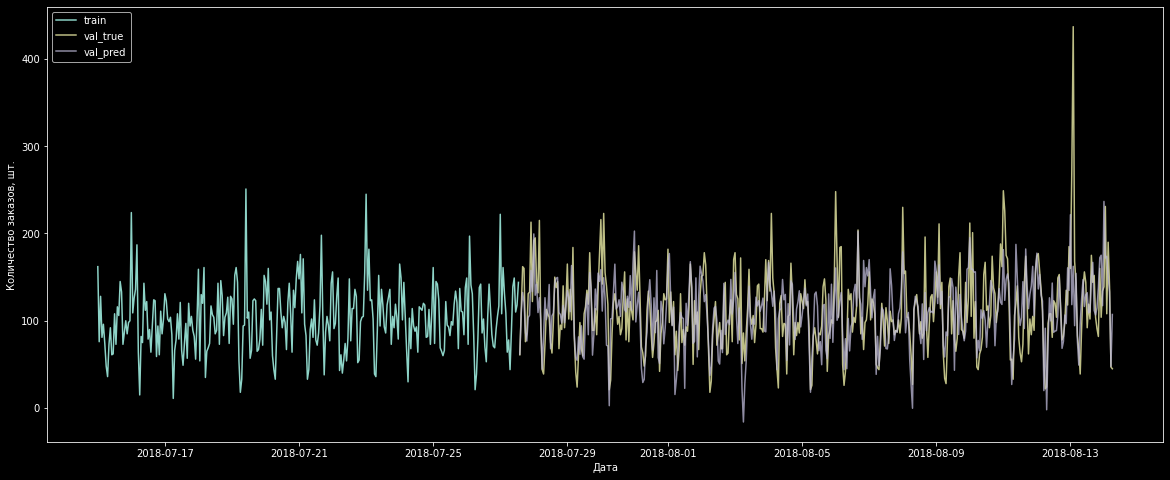

In [ ]:
plot_pred("baseline")
plt.show()

Из графика видно, что предсказания содержат большое количество выбросов, в то время как, выбросы действительных значений не предсказаны.
Однако, в целом, предсказания соответствуют действительным значениям по среднему значению и размаху.

## Линейная регрессия

Определим модель линейной регрессии и получим значение метрики на валидационной выборке.

In [ ]:
lin = LinearRegression()

lin.fit(train[X], train[y])
val["pred_lin"] = lin.predict(val[X])
mse_lin = mean_squared_error(val[y], val["pred_lin"], squared=False)
mse_lin, (mse_baseline - mse_lin) / mse_baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(30.67645010969072, 0.21134866508769737)

Модель линейной регрессии позволяет получить значение целевой метрики на уровне 33 заказов, что на 21% лучше значения опорного предсказания.
Примечательно, что полученное значение соизмеримо с дисперсией шумовой составляющей, которая, по всей видимости, определяет точность полученной модели.

Для наглядности построим график действительных значений и предсказанных.

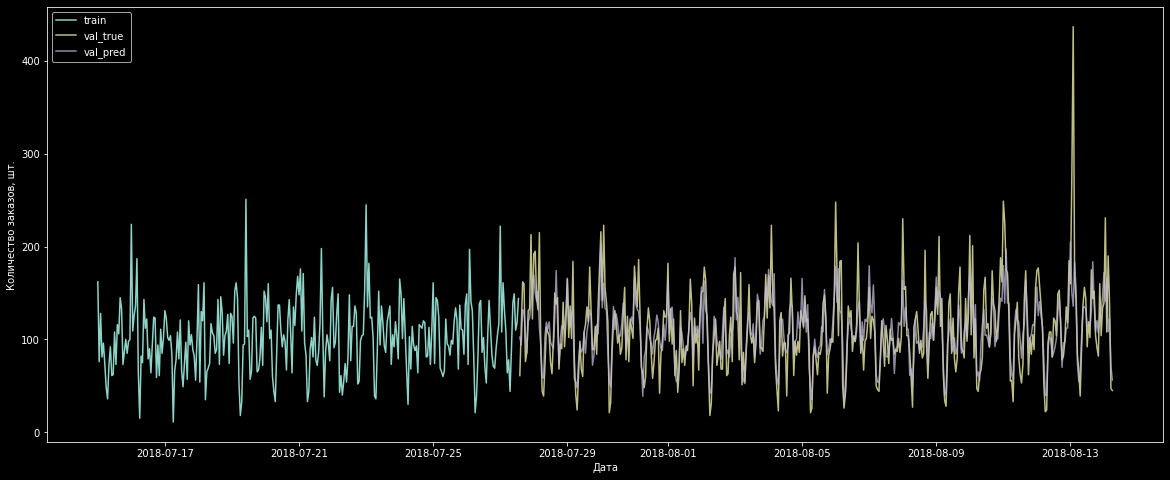

In [ ]:
plot_pred("pred_lin")
plt.show()

По графику видно, что в отличие от опорной модели, модель линейной регрессии лучше предсказывает выбросы в данных и практически не имеет ложных выбросов.
В то же время большое количество данных предсказано неверно.

## Catboost

Определим одну из самых популярных моделей градиентного бустинга - Catboost.
Получим значение метрики на валидационной выборке.

In [ ]:
train_pool = Pool(data=train[X], label=train[y])
val_pool = Pool(data=val[X], label=val[y])

In [ ]:
parameters = {
    "learning_rate": 0.01,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 26,
    "verbose": 250,
    "has_time": True,
    "early_stopping_rounds": 200,
}
meow = CatBoostRegressor(**parameters)
meow.fit(train_pool, eval_set=val_pool)
val["pred_meow"] = meow.predict(val[X])

mse_meow = mean_squared_error(val[y], val["pred_meow"], squared=False)
mse_meow, (mse_lin - mse_meow) / mse_lin

0:	learn: 35.6413101	test: 58.3660478	best: 58.3660478 (0)	total: 47.4ms	remaining: 47.3s
250:	learn: 20.3361691	test: 33.5966268	best: 33.5966268 (250)	total: 406ms	remaining: 1.21s
500:	learn: 19.3812597	test: 31.2495007	best: 31.2495007 (500)	total: 766ms	remaining: 763ms
750:	learn: 18.8866124	test: 30.7870200	best: 30.7858509 (749)	total: 1.08s	remaining: 359ms
999:	learn: 18.4955266	test: 30.6602796	best: 30.6571294 (987)	total: 1.4s	remaining: 0us

bestTest = 30.65712944
bestIteration = 987

Shrink model to first 988 iterations.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(30.65712943890621, 0.0006298209445820414)

Полученное значение метрики почти равно аналогичному для модели линейной регрессии.
Построим график предсказания.

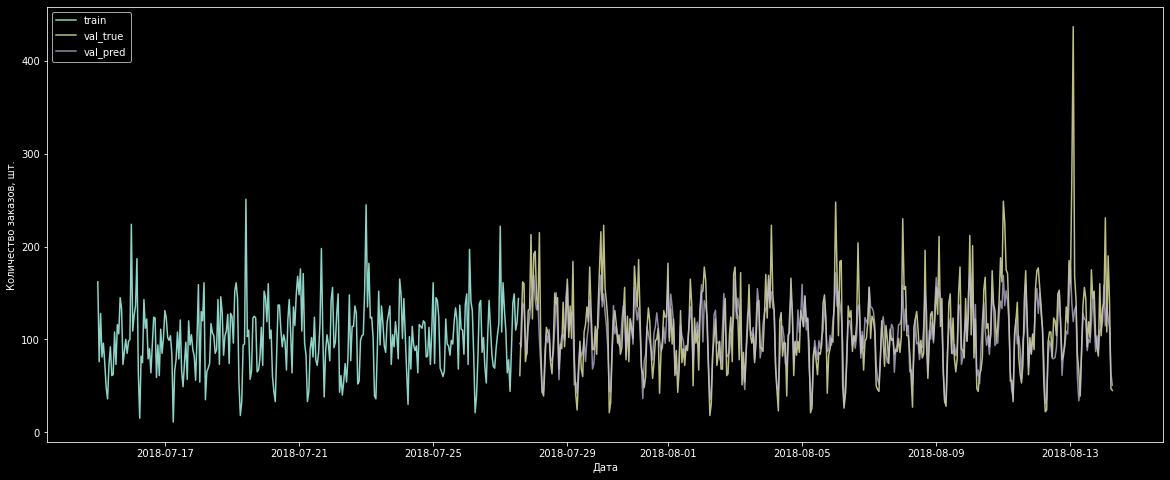

In [ ]:
plot_pred("pred_meow")
plt.show()

По графику видно, что предсказания модели достаточно хорошо соответствуют действительным значениям в области среддних значений, но плохо "отрабатывают" выборсы.

## Prophet

Оценим целесообразность применения для поставленной задачи еще одной популярной модели - Prophet.
Для этого обучим ее на тренировочной выборке.

In [ ]:
proph = Prophet()
proph.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg6ge76f/2n5ll3ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwg6ge76f/tt22k4a_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56329', 'data', 'file=/tmp/tmpwg6ge76f/2n5ll3ys.json', 'init=/tmp/tmpwg6ge76f/tt22k4a_.json', 'output', 'file=/tmp/tmp43_yvktw/prophet_model-20220829114050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:40:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Создадим датафрейм, подходящий для предсказания и выполним само предсказание.

In [ ]:
future = proph.make_future_dataframe(periods=len(val)+len(test))

In [ ]:
forecast = proph.predict(future)

Оценим качество предсказания на целевой метрике.

In [ ]:
mse_prophet = mean_squared_error(test[y], forecast['yhat'].tail(len(test)), squared=False)
mse_prophet

309.3971152101885

Полученное значение существенно превосходит полученные на других моделях.
С целью анализа полученного результата построим график предсказания.

In [ ]:
df['pred_prophet'] = forecast['yhat'].values

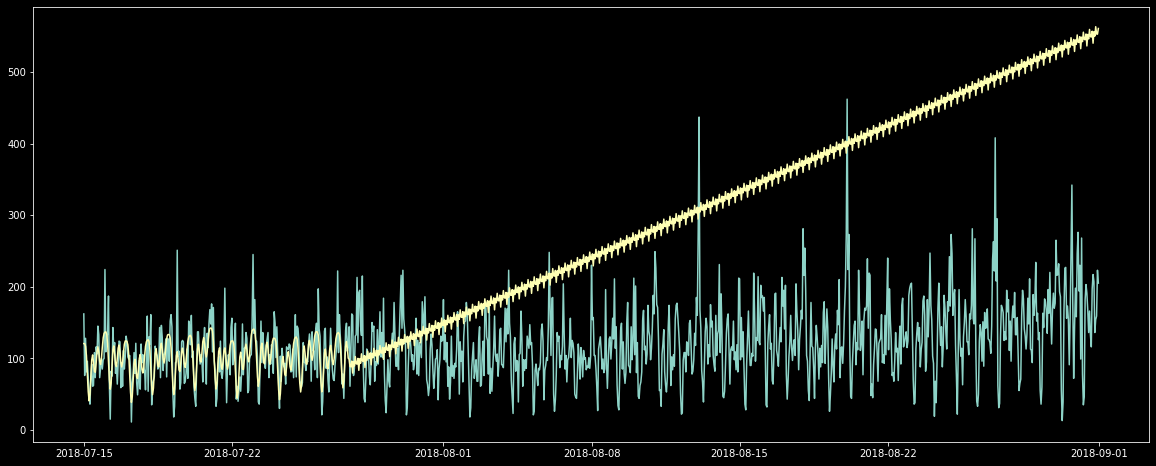

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df[['y', 'pred_prophet']]["2018-07-15":])
plt.show()

По графику видно, что модель Prophet предсказывает тренд с шумами, что не отражает действительного изменения количества заказов такси.
В этой связи, рассмотренная модель не пригодна для решения поставленной задачи.

## Проверка модели на тестовой выборке

Учитывая, что на валидационной выборке значение целевой метрики моделей линейной регрессии и Catboost отличаются незначительно, проверку на тестовой выборке осуществим для обоих моделей.

In [ ]:
test["pred_meow"] = meow.predict(test[X])
mse_lin_test = mean_squared_error(test[y], test["pred_meow"], squared=False)
mse_lin_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


49.46224338890194

In [ ]:
test["pred_lin"] = lin.predict(test[X])
mse_lin_test = mean_squared_error(test[y], test["pred_lin"], squared=False)
mse_lin_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


35.57046933991732

Значение метрики для модели Catboost выше заданного предела.
В этой связи для решения поставленной задачи наиболее точное решение обеспечивает модель линейной регрессии.

Построим график действительной функции и предсказанной моделью линейно регрессии.

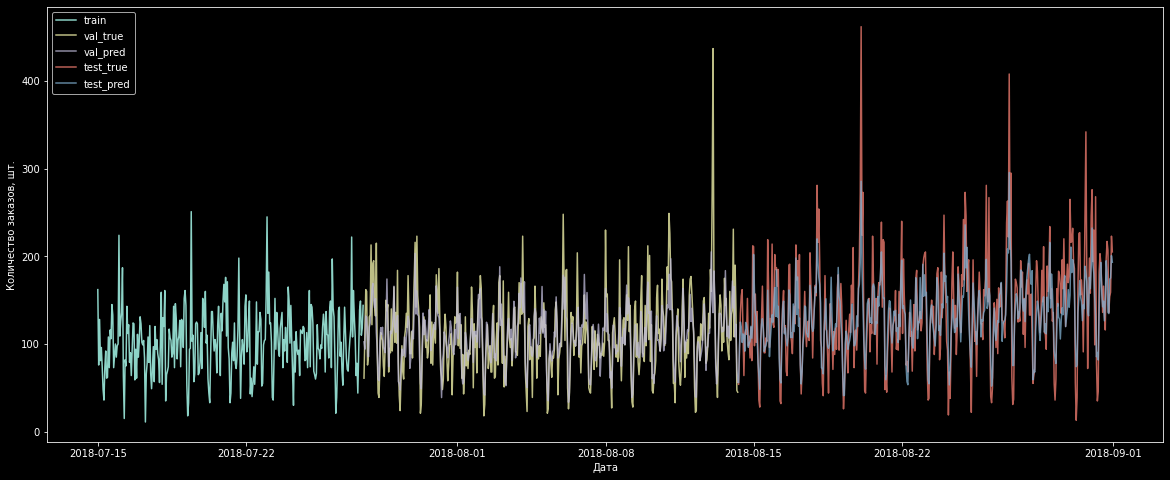

In [ ]:
plot_pred("pred_lin")
plt.plot(test[y], label="test_true", alpha=0.75)
plt.plot(test["pred_lin"], label="test_pred", alpha=0.75)
plt.legend(loc=2)
plt.show()

Значение метрики удовлетворяет заданному значению. 
В то же время, по графику видно, что предсказания модели ошибаются в основном на выбросах в данных. 

Для оценки качества предсказания модели Catboost сравним ее со значением метрики аналитического решения!

In [ ]:
test["baseline"] = (
    test["rolling_mean_shift_1"]
    + (test["rolling_mean_shift_2"] - test["rolling_mean_shift_1"]) / 2
    + test["seasonal"]
    + test["noise"]
)
mse_baseline_test = mean_squared_error(test[y], test["baseline"], squared=False)
mse_baseline_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


50.936587308302244

Полученное значение больше метрики модели Catboost менее чем на 3%.


# Выводы

Проведена работа по построению модели предсказания количества заказов такси на следующий час с целью привлечения больше водителей в период пиковой нагрузки.

Проведен исследовательский анализ данных, в ходе которого определено наличие тренда, сезонности и шумовой составляющей в данных.
На основе анализа сформированы новые признаки для построения модели машинного обучения.

Рассмотрены три модели машинного обучения для предсказания количества заказов такси: аналитическая, линейная регрессия, Catboost. 
По результатам проверки значения RMSE на валидационной выборке, лучшей моделью является линейная регрессия, затем аналитическая и Catboost, а Prophet - на последнем месте.
На тестовой выборке, размер которой составляет 10% от исходных данных, значение RMSE линейной регрессии составляет 35 при заданном пороге 48.